# Data Preprocessing and Splitting
---

In [28]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

import sys
sys.path.append('../scripts')
from create_labels import column_order, labels, create_labels
from extract_imgs import find_img_folder, move_imgs

In [29]:
# load data

bbox_df = pd.read_pickle('../data/interim/bbox_df.pkl')
data_entry_df = pd.read_pickle('../data/interim/data_entry_df.pkl')
train_val_list = pd.read_pickle('../data/interim/train_val_list.pkl')
test_list = pd.read_pickle('../data/interim/test_list.pkl')
patient_data = pd.read_pickle('../data/interim/patient_data.pkl')

In [30]:
# show unique classes
labels_exploded = data_entry_df["finding_labels"].str.split('|').explode()
sorted(labels_exploded.unique())

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

## Create Labels

### Encode Features

In [31]:
# inner joined data between data_entry_df and both test and training datasets
# created a new filtered dataset where it includes data from both datasets only where 'image_index' matches both datasets

filtered_test_list = data_entry_df.merge(test_list, on='image_index', how='inner')
filtered_train_val_list = data_entry_df.merge(train_val_list, on='image_index', how='inner')

display(filtered_test_list.head())
display(filtered_train_val_list.head())

,image_index,finding_labels,follow_up_number,patient_id,patient_age,patient_gender,view_position,original_img_width,original_img_height,img_pixel_spacing_x,img_pixel_spacing_y
0,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143
1,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,0.168
2,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,0.168
3,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,0.143,0.143
4,00000003_004.png,Hernia,4,3,77,F,PA,2500,2048,0.168,0.168


,image_index,finding_labels,follow_up_number,patient_id,patient_age,patient_gender,view_position,original_img_width,original_img_height,img_pixel_spacing_x,img_pixel_spacing_y
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
4,00000004_000.png,Mass|Nodule,0,4,82,M,AP,2500,2048,0.168,0.168


In [32]:
# encode target variable classes (train_val_list)
train_X = filtered_train_val_list.drop("finding_labels", axis=1)
train_y = filtered_train_val_list["finding_labels"]

train_val_labels = create_labels(train_X, train_y)
train_val_labels.head()

,image_index,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,...,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,follow_up_number,patient_id,patient_age,patient_gender,view_position
0,00000001_000.png,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,58,M,PA
1,00000001_001.png,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,1,58,M,PA
2,00000001_002.png,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,2,1,58,M,PA
3,00000002_000.png,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,2,81,M,PA
4,00000004_000.png,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,4,82,M,AP


In [33]:
# encode target variable classes (test_list)
test_X = filtered_test_list.drop("finding_labels", axis=1)
test_y = filtered_test_list["finding_labels"]

test_labels = create_labels(test_X,test_y)
test_labels.head()

,image_index,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,...,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,follow_up_number,patient_id,patient_age,patient_gender,view_position
0,00000003_000.png,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,3,81,F,PA
1,00000003_001.png,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,3,74,F,PA
2,00000003_002.png,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,2,3,75,F,PA
3,00000003_003.png,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,3,3,76,F,PA
4,00000003_004.png,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,4,3,77,F,PA


In [34]:
# emcode patient_gender and view_position columns (test_label)

test_labels["patient_gender"] = label_encoder.fit_transform(test_labels["patient_gender"])
print("Category mapping:")
for i, category in enumerate(label_encoder.classes_):
    print(f"{category}: {i}")

test_labels["view_position"] = label_encoder.fit_transform(test_labels["view_position"])
print("Category mapping:")
for i, category in enumerate(label_encoder.classes_):
    print(f"{category}: {i}")

test_labels[["patient_gender", "view_position"]].head()

Category mapping:
F: 0
M: 1
Category mapping:
AP: 0
PA: 1


,patient_gender,view_position
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [35]:
# emcode patient_gender and view_position columns (train_val_label)

train_val_labels["patient_gender"] = label_encoder.fit_transform(train_val_labels["patient_gender"])
print("Category mapping:")
for i, category in enumerate(label_encoder.classes_):
    print(f"{category}: {i}")

train_val_labels["view_position"] = label_encoder.fit_transform(train_val_labels["view_position"])
print("Category mapping:")
for i, category in enumerate(label_encoder.classes_):
    print(f"{category}: {i}")

train_val_labels[["patient_gender", "view_position"]].head()

Category mapping:
F: 0
M: 1
Category mapping:
AP: 0
PA: 1


,patient_gender,view_position
0,1,1
1,1,1
2,1,1
3,1,1
4,1,0


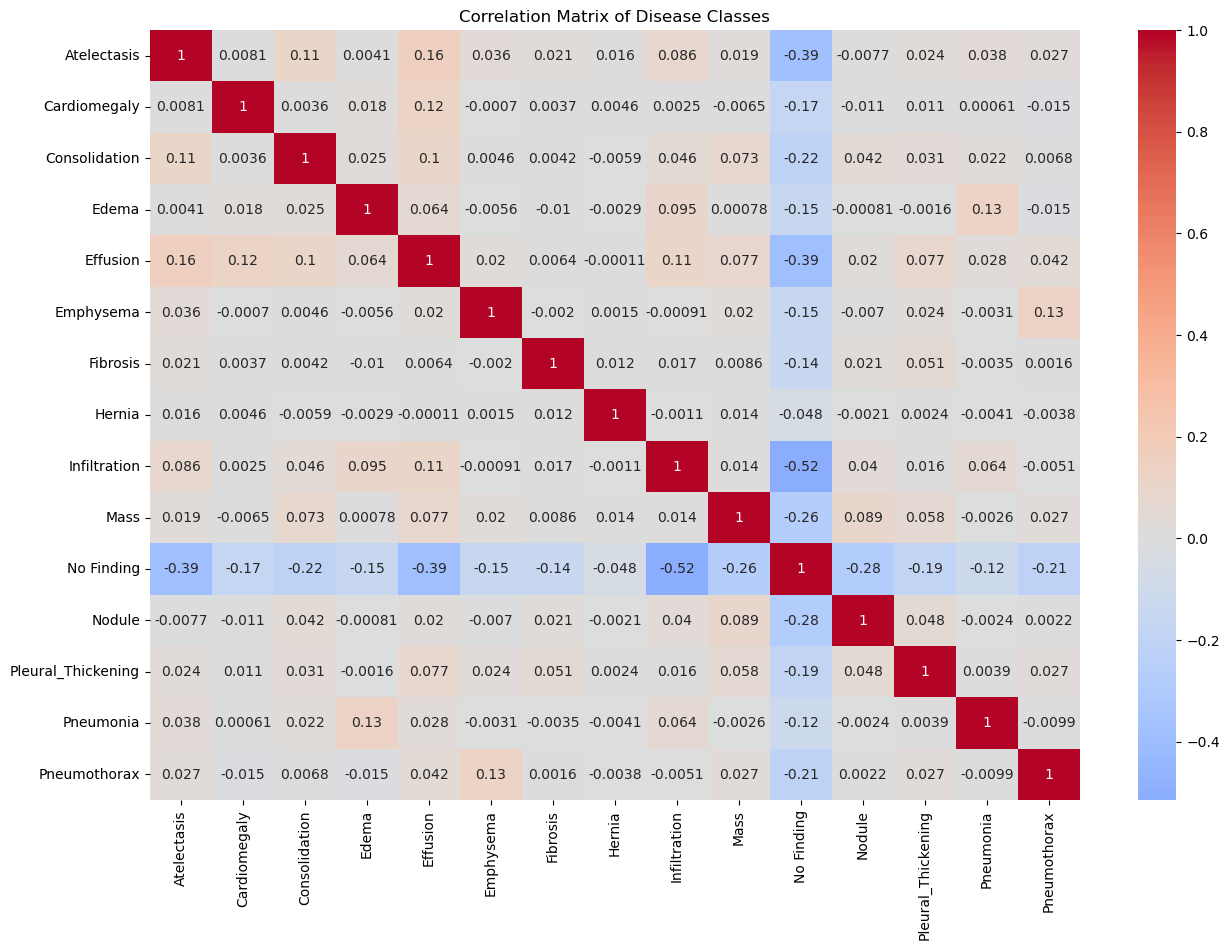

In [36]:
# Created a correlation matrix higlighting the linear association between each class

y = train_val_labels.drop(columns=['image_index','follow_up_number', 'patient_id', 'patient_age', 'patient_gender', 'view_position'])
corr_matrix = y.corr()

plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Disease Classes')
plt.show()

- As expected, the No Findings class has a negative correlation iwht every other class, with the highest negative correlation being the Infiltration class at -0.52
- There is a weak positive correlation between other classes such as the Inflitration and Edema class at 0.095, Actelectasis and Effusion class at 0.16, and the Effusion and Edema class at 0.064, indicating that there is a slight tendency for these classes to occur at the same time
- Additionally, there are also some classes that have a near 0 correlation such as the Cardiomegaly and Emphysema class at 0.0046 or the Edema and Mass class at 0.00078, signifying that these classes are independent of each other 

### Data Sampling
- Discovered there is an imbalace samples in each classes
- Stratified sampling

In [37]:
train_val_labels

,image_index,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,...,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,follow_up_number,patient_id,patient_age,patient_gender,view_position
0,00000001_000.png,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,58,1,1
1,00000001_001.png,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,1,58,1,1
2,00000001_002.png,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,2,1,58,1,1
3,00000002_000.png,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,2,81,1,1
4,00000004_000.png,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,4,82,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86506,00030786_007.png,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,7,30786,61,0,0
86507,00030789_000.png,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,30789,52,0,1
86508,00030793_000.png,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,30793,58,0,1
86509,00030795_000.png,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,30795,53,0,1


### Data Splitting

In [38]:
# performed train_test_split on the train_val_list dataset to obtain 80/20 split (80% - train, 20% validation)
train_val_X = train_val_labels.drop(labels, axis=1)
train_val_y = train_val_labels[labels]

X_train, X_val, y_train, y_val = train_test_split(train_val_X, train_val_y, test_size=0.2, random_state=42)

# combined the training sets and validation sets
train_labels = pd.concat([X_train, y_train],axis=1).reindex(columns=column_order)
val_labels = pd.concat([X_val, y_val],axis=1).reindex(columns=column_order)

display(train_labels.head())
display(val_labels.head())


,image_index,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,...,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,follow_up_number,patient_id,patient_age,patient_gender,view_position
5248,00001739_000.png,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1739,57,0,1
34668,00010741_016.png,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,16,10741,81,0,1
14188,00004552_000.png,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4552,56,1,1
70256,00022090_000.png,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,22090,30,0,1
69107,00021627_005.png,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,5,21627,42,1,0


,image_index,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,...,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,follow_up_number,patient_id,patient_age,patient_gender,view_position
49657,00015355_007.png,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,7,15355,69,1,0
43843,00013572_004.png,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,4,13572,61,0,0
84853,00029465_002.png,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,2,29465,55,0,1
28824,00009001_004.png,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,4,9001,48,0,1
11597,00003616_000.png,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,3616,52,1,1


In [39]:
# export files to the labels folder

train_labels.to_csv('../data/labels/train_labels.csv')
val_labels.to_csv('../data/labels/val_labels.csv')
test_labels.to_csv('../data/labels/test_labels.csv')

## Extract Raw Data

In [40]:
# locate the parent folder of each label dataset using find_imag_folder script
# Parent folders are then appended to each respective dataset

train_labels = find_img_folder(train_labels)
val_labels = find_img_folder(val_labels)
test_labels = find_img_folder(test_labels)

In [41]:
# move images to their respective folders
"""
move_imgs(train_labels, "../data/train_imgs")
move_imgs(val_labels, "../data/val_imgs")
move_imgs(test_labels, "../data/test_imgs")
"""

'\nmove_imgs(train_labels, "../data/train_imgs")\nmove_imgs(val_labels, "../data/val_imgs")\nmove_imgs(test_labels, "../data/test_imgs")\n'